# Check the Python version being used

In [1]:
!python --version

# Check that the available gpu is being utilized

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available")
print(len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available
1


# Start of second method of lstm time series forecasting

In [4]:
from pandas import read_csv

df = read_csv('Time_Series_For_Clustering_El_Paso_Final.csv')

# get each separate time series as an individual list and append each of these lists to a master list

In [5]:
import re
import pandas as pd

non_decimal = re.compile(r'[^\d.]+')

list_of_training_df = []
list_of_row_components = []

for i in range(1, 524):
    
    current_row = df.iloc[i]
    
    bridge_id = current_row.iloc[0]
    
    current_row = current_row.iloc[1:]
    
    for j, row in current_row.iteritems():
        
        current_row_components = row.split(', ')
        current_row_components_replaced = []

        for idx, component in enumerate(current_row_components):

            result = non_decimal.sub('', current_row_components[idx])
            current_row_components_replaced.append(float(result))

        list_of_row_components.append(current_row_components_replaced)

# Ensure each element in the list of lists is a float

In [6]:
for idx, element in enumerate(list_of_row_components):
    for i in range(1, len(element)):
        list_of_row_components[idx][i] = float(list_of_row_components[idx][i])

# View one time series

In [7]:
for i in range(22):
    print(list_of_row_components[i])

[36.0, 97.0, 428.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.3, 97.0, 955.0, 1949.0, 2.0, 11.0, 7.0]
[36.3, 96.9, 955.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 97.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 522.0, 1949.0, 2.0, 9.7, 7.3]


# Get length of list of lists

In [8]:
len(list_of_row_components)

11506

# Swap last entry with second entry in time series to make the output predictor variable Sufficiency Rating

In [9]:
for idx, component in enumerate(list_of_row_components):
    temp = component[6]
    list_of_row_components[idx][6] = list_of_row_components[idx][1]
    list_of_row_components[idx][1] = temp

# Convert format of list to have a single time series for each index

In [10]:
import numpy as np

list_of_examples = []
temp_list = []

max_num = 22
iter = 0;

for row_component in list_of_row_components:
    if iter == max_num:
        list_of_examples.append(np.array(temp_list))
        temp_list = []
        iter = 0
        
    temp_list.append(np.array(row_component))
    iter += 1

list_of_examples = np.array(list_of_examples)

# Make the very last time step of each time series just a single value (Sufficiency Rating) for the model to predict on

In [11]:
for idx, example in enumerate(list_of_examples):
    list_of_examples[idx][21] = [list_of_examples[idx][21][6]]

# Perform train test split for dataset

In [12]:
from sklearn.model_selection import train_test_split

n_train_periods = 300
train = list_of_examples[:n_train_periods, :]
test = list_of_examples[n_train_periods:, :]

# split into input and outputs
train_X, train_y = train[:, :-1, 1:], train[:, -1, 0]
test_X, test_y = test[:, :-1, 1:], test[:, -1, 0]


In [13]:
print("Shape of train_X: " + str(train_X.shape))
print("Shape of train_y: " + str(train_y.shape))
print("Shape of test_X: " + str(test_X.shape))
print("Shape of test_y: " + str(test_y.shape))

Shape of train_X: (300, 21, 6)
Shape of train_y: (300,)
Shape of test_X: (222, 21, 6)
Shape of test_y: (222,)


# Build GRU model

In [14]:
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(50, dropout=0.2, recurrent_dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2])),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1)
])

# Compile model

In [15]:
gru_model.compile(loss='mae', optimizer='adam')

# Train model

In [16]:
history = gru_model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/1000
10/10 - 1s - loss: 81.2856 - val_loss: 73.5999
Epoch 2/1000
10/10 - 0s - loss: 79.0759 - val_loss: 72.3063
Epoch 3/1000
10/10 - 0s - loss: 76.8022 - val_loss: 71.0079
Epoch 4/1000
10/10 - 0s - loss: 74.3044 - val_loss: 69.5680
Epoch 5/1000
10/10 - 0s - loss: 71.2764 - val_loss: 67.9086
Epoch 6/1000
10/10 - 0s - loss: 68.1482 - val_loss: 65.8676
Epoch 7/1000
10/10 - 0s - loss: 64.4052 - val_loss: 63.6458
Epoch 8/1000
10/10 - 0s - loss: 60.3059 - val_loss: 60.9921
Epoch 9/1000
10/10 - 0s - loss: 54.6331 - val_loss: 58.0193
Epoch 10/1000
10/10 - 0s - loss: 49.5132 - val_loss: 53.1430
Epoch 11/1000
10/10 - 0s - loss: 42.6538 - val_loss: 48.1820
Epoch 12/1000
10/10 - 0s - loss: 36.8864 - val_loss: 43.3451
Epoch 13/1000
10/10 - 0s - loss: 31.5148 - val_loss: 38.9315
Epoch 14/1000
10/10 - 0s - loss: 25.9713 - val_loss: 34.4889
Epoch 15/1000
10/10 - 0s - loss: 21.3289 - val_loss: 32.1508
Epoch 16/1000
10/10 - 0s - loss: 19.0820 - val_loss: 27.6716
Epoch 17/1000
10/10 - 0s - loss: 

Epoch 135/1000
10/10 - 0s - loss: 14.6493 - val_loss: 20.4787
Epoch 136/1000
10/10 - 0s - loss: 14.1876 - val_loss: 20.4802
Epoch 137/1000
10/10 - 0s - loss: 14.4101 - val_loss: 20.3438
Epoch 138/1000
10/10 - 0s - loss: 14.1866 - val_loss: 20.3290
Epoch 139/1000
10/10 - 0s - loss: 14.7016 - val_loss: 20.3441
Epoch 140/1000
10/10 - 0s - loss: 14.5745 - val_loss: 20.3019
Epoch 141/1000
10/10 - 0s - loss: 14.6832 - val_loss: 20.4387
Epoch 142/1000
10/10 - 0s - loss: 14.4276 - val_loss: 20.5205
Epoch 143/1000
10/10 - 1s - loss: 14.3924 - val_loss: 20.5052
Epoch 144/1000
10/10 - 0s - loss: 14.8266 - val_loss: 20.4090
Epoch 145/1000
10/10 - 0s - loss: 14.2403 - val_loss: 20.8850
Epoch 146/1000
10/10 - 0s - loss: 14.0660 - val_loss: 21.2499
Epoch 147/1000
10/10 - 0s - loss: 14.3263 - val_loss: 21.5076
Epoch 148/1000
10/10 - 0s - loss: 14.5758 - val_loss: 21.6946
Epoch 149/1000
10/10 - 0s - loss: 14.3419 - val_loss: 21.4577
Epoch 150/1000
10/10 - 0s - loss: 14.4862 - val_loss: 21.2738
Epoch 15

10/10 - 0s - loss: 13.0461 - val_loss: 17.1408
Epoch 268/1000
10/10 - 0s - loss: 13.3646 - val_loss: 17.0489
Epoch 269/1000
10/10 - 0s - loss: 13.7432 - val_loss: 17.3626
Epoch 270/1000
10/10 - 0s - loss: 13.6776 - val_loss: 18.3853
Epoch 271/1000
10/10 - 0s - loss: 13.7220 - val_loss: 17.8459
Epoch 272/1000
10/10 - 0s - loss: 13.0443 - val_loss: 16.8645
Epoch 273/1000
10/10 - 0s - loss: 12.8824 - val_loss: 16.6700
Epoch 274/1000
10/10 - 0s - loss: 13.3226 - val_loss: 16.5964
Epoch 275/1000
10/10 - 0s - loss: 13.5226 - val_loss: 17.5168
Epoch 276/1000
10/10 - 0s - loss: 13.3900 - val_loss: 17.3981
Epoch 277/1000
10/10 - 0s - loss: 13.3987 - val_loss: 16.2767
Epoch 278/1000
10/10 - 0s - loss: 12.8394 - val_loss: 16.9329
Epoch 279/1000
10/10 - 0s - loss: 13.2647 - val_loss: 17.1241
Epoch 280/1000
10/10 - 0s - loss: 12.7120 - val_loss: 16.6638
Epoch 281/1000
10/10 - 0s - loss: 13.2670 - val_loss: 16.2565
Epoch 282/1000
10/10 - 0s - loss: 12.6030 - val_loss: 16.5237
Epoch 283/1000
10/10 - 

Epoch 400/1000
10/10 - 0s - loss: 11.8826 - val_loss: 19.1446
Epoch 401/1000
10/10 - 0s - loss: 11.8637 - val_loss: 18.3953
Epoch 402/1000
10/10 - 0s - loss: 12.4835 - val_loss: 18.7994
Epoch 403/1000
10/10 - 0s - loss: 12.1732 - val_loss: 19.1236
Epoch 404/1000
10/10 - 0s - loss: 11.8467 - val_loss: 19.1163
Epoch 405/1000
10/10 - 0s - loss: 11.3024 - val_loss: 19.2762
Epoch 406/1000
10/10 - 0s - loss: 12.1762 - val_loss: 18.9488
Epoch 407/1000
10/10 - 0s - loss: 12.0794 - val_loss: 19.5155
Epoch 408/1000
10/10 - 0s - loss: 11.8565 - val_loss: 19.9311
Epoch 409/1000
10/10 - 0s - loss: 11.5245 - val_loss: 20.0262
Epoch 410/1000
10/10 - 0s - loss: 12.2762 - val_loss: 20.0216
Epoch 411/1000
10/10 - 1s - loss: 12.1031 - val_loss: 18.9498
Epoch 412/1000
10/10 - 0s - loss: 11.5717 - val_loss: 19.0530
Epoch 413/1000
10/10 - 0s - loss: 11.5212 - val_loss: 18.9145
Epoch 414/1000
10/10 - 0s - loss: 11.6452 - val_loss: 19.2271
Epoch 415/1000
10/10 - 0s - loss: 12.2009 - val_loss: 19.5407
Epoch 41

10/10 - 0s - loss: 12.0569 - val_loss: 17.3537
Epoch 533/1000
10/10 - 0s - loss: 12.4569 - val_loss: 17.3614
Epoch 534/1000
10/10 - 0s - loss: 12.4413 - val_loss: 17.6452
Epoch 535/1000
10/10 - 0s - loss: 12.8295 - val_loss: 17.1477
Epoch 536/1000
10/10 - 0s - loss: 12.7060 - val_loss: 16.6011
Epoch 537/1000
10/10 - 0s - loss: 13.0361 - val_loss: 16.8884
Epoch 538/1000
10/10 - 0s - loss: 12.2426 - val_loss: 17.0209
Epoch 539/1000
10/10 - 0s - loss: 13.1054 - val_loss: 16.6576
Epoch 540/1000
10/10 - 0s - loss: 12.6025 - val_loss: 16.8003
Epoch 541/1000
10/10 - 0s - loss: 12.1972 - val_loss: 16.8532
Epoch 542/1000
10/10 - 0s - loss: 11.8198 - val_loss: 16.5640
Epoch 543/1000
10/10 - 0s - loss: 13.0826 - val_loss: 16.2532
Epoch 544/1000
10/10 - 0s - loss: 12.0011 - val_loss: 16.6032
Epoch 545/1000
10/10 - 0s - loss: 13.0986 - val_loss: 16.2856
Epoch 546/1000
10/10 - 0s - loss: 13.0967 - val_loss: 16.0389
Epoch 547/1000
10/10 - 0s - loss: 12.5184 - val_loss: 16.0029
Epoch 548/1000
10/10 - 

Epoch 665/1000
10/10 - 0s - loss: 11.3037 - val_loss: 16.3693
Epoch 666/1000
10/10 - 0s - loss: 11.0615 - val_loss: 16.4841
Epoch 667/1000
10/10 - 0s - loss: 11.3204 - val_loss: 16.4087
Epoch 668/1000
10/10 - 1s - loss: 11.2839 - val_loss: 16.3437
Epoch 669/1000
10/10 - 0s - loss: 11.9093 - val_loss: 15.8862
Epoch 670/1000
10/10 - 0s - loss: 11.7491 - val_loss: 15.9806
Epoch 671/1000
10/10 - 0s - loss: 11.1370 - val_loss: 15.9181
Epoch 672/1000
10/10 - 0s - loss: 11.3526 - val_loss: 15.6785
Epoch 673/1000
10/10 - 0s - loss: 11.2781 - val_loss: 15.4728
Epoch 674/1000
10/10 - 0s - loss: 11.5664 - val_loss: 15.3918
Epoch 675/1000
10/10 - 0s - loss: 11.0454 - val_loss: 15.7122
Epoch 676/1000
10/10 - 0s - loss: 11.3405 - val_loss: 15.8599
Epoch 677/1000
10/10 - 0s - loss: 11.8453 - val_loss: 15.5492
Epoch 678/1000
10/10 - 0s - loss: 10.7288 - val_loss: 15.3778
Epoch 679/1000
10/10 - 0s - loss: 11.7702 - val_loss: 15.3106
Epoch 680/1000
10/10 - 0s - loss: 12.4874 - val_loss: 15.0760
Epoch 68

10/10 - 0s - loss: 9.7415 - val_loss: 16.7018
Epoch 798/1000
10/10 - 0s - loss: 9.7298 - val_loss: 17.1155
Epoch 799/1000
10/10 - 0s - loss: 11.1337 - val_loss: 17.5836
Epoch 800/1000
10/10 - 0s - loss: 10.7508 - val_loss: 17.7925
Epoch 801/1000
10/10 - 0s - loss: 10.9529 - val_loss: 17.9467
Epoch 802/1000
10/10 - 0s - loss: 10.9762 - val_loss: 18.6840
Epoch 803/1000
10/10 - 0s - loss: 11.5240 - val_loss: 17.7383
Epoch 804/1000
10/10 - 0s - loss: 12.7739 - val_loss: 16.5926
Epoch 805/1000
10/10 - 0s - loss: 9.8046 - val_loss: 15.7316
Epoch 806/1000
10/10 - 0s - loss: 10.5151 - val_loss: 17.1624
Epoch 807/1000
10/10 - 0s - loss: 10.4999 - val_loss: 16.8134
Epoch 808/1000
10/10 - 0s - loss: 10.2369 - val_loss: 14.4692
Epoch 809/1000
10/10 - 0s - loss: 10.0968 - val_loss: 14.9753
Epoch 810/1000
10/10 - 0s - loss: 11.7027 - val_loss: 15.0187
Epoch 811/1000
10/10 - 0s - loss: 11.0918 - val_loss: 14.8446
Epoch 812/1000
10/10 - 0s - loss: 11.0148 - val_loss: 14.9750
Epoch 813/1000
10/10 - 0s 

Epoch 930/1000
10/10 - 0s - loss: 11.3866 - val_loss: 15.5487
Epoch 931/1000
10/10 - 0s - loss: 11.4903 - val_loss: 15.3063
Epoch 932/1000
10/10 - 0s - loss: 11.0062 - val_loss: 15.0904
Epoch 933/1000
10/10 - 0s - loss: 12.2249 - val_loss: 15.1714
Epoch 934/1000
10/10 - 0s - loss: 11.9027 - val_loss: 15.2422
Epoch 935/1000
10/10 - 0s - loss: 11.3590 - val_loss: 15.1736
Epoch 936/1000
10/10 - 0s - loss: 11.9518 - val_loss: 15.2066
Epoch 937/1000
10/10 - 0s - loss: 11.1535 - val_loss: 14.0126
Epoch 938/1000
10/10 - 1s - loss: 12.3664 - val_loss: 14.6295
Epoch 939/1000
10/10 - 1s - loss: 10.5210 - val_loss: 14.8383
Epoch 940/1000
10/10 - 1s - loss: 10.8713 - val_loss: 13.9119
Epoch 941/1000
10/10 - 1s - loss: 11.6516 - val_loss: 13.6976
Epoch 942/1000
10/10 - 1s - loss: 11.1176 - val_loss: 14.6830
Epoch 943/1000
10/10 - 1s - loss: 10.3183 - val_loss: 14.9072
Epoch 944/1000
10/10 - 1s - loss: 11.2386 - val_loss: 14.9364
Epoch 945/1000
10/10 - 1s - loss: 11.1075 - val_loss: 14.8562
Epoch 94

# Plot model loss and validation loss

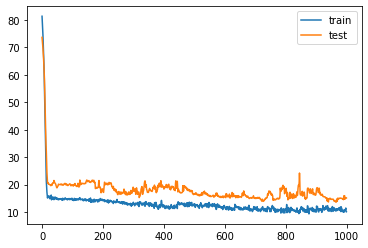

In [17]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# We now get the RMSE for both train and test sets to see if they differ by much

# Make predictions based on train set and get a root mean squared error 

In [18]:
from sklearn.metrics import mean_squared_error
import math

train_yhat = gru_model.predict(train_X)
mse = mean_squared_error(train_y, train_yhat)
rmse = math.sqrt(mse)

In [19]:
print('Train RMSE: ' + str(rmse))

Train RMSE: 20.92795025967811


# Make predictions based on test set and get a root mean squared error 

In [20]:
from sklearn.metrics import mean_squared_error
import math

test_yhat = gru_model.predict(test_X)
mse = mean_squared_error(test_y, test_yhat)
rmse = math.sqrt(mse)

In [21]:
print('Test RMSE: ' + str(rmse))

Test RMSE: 19.39197704962869


# Plot train labels along with train predictions

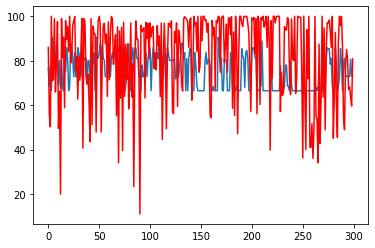

In [22]:
from matplotlib import pyplot

pyplot.plot(train_yhat, label='actual')
pyplot.plot(train_y, color='red', label='predicted')
pyplot.show()

# Plot test labels along with test predictions

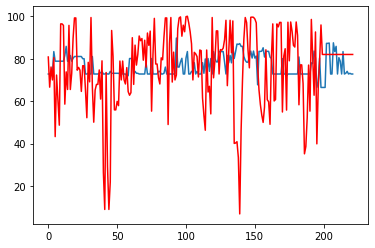

In [23]:
from matplotlib import pyplot

pyplot.plot(test_yhat, label='actual')
pyplot.plot(test_y, color='red', label='predicted')
pyplot.show()